In [142]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

# Add the directory where dynamics.py and utils.py are located to sys.path
module_path = os.path.abspath(os.path.join('../src'))
if module_path not in sys.path:
    sys.path.append(module_path)

from tqdm import tqdm
from dynamics import SatelliteDynamics
from scipy.optimize import approx_fprime
from scipy.linalg import block_diag, solve
from utils import get_form_initial_conditions

In [143]:
# Simulation parameters
dt = 60.0  # Time step [s]
T = 395  # Duration [min]
T_RMSE = 300  # Index from which the RMSE is calculated
M = 1  # Number of Monte-Carlo simulations
N = 4  # Number of satellites
formation = 1
n_x = 6  # Number of states
n_p = 3  
n_y_1 = 3  # Number of measurements
n_y_2 = 2
n_y_3 = 2
n_y_4 = 2
K = T
W = 100 # Window size [min]

In [144]:
# Initial state vector and get the true state vectors (propagation) F
X_initial = get_form_initial_conditions(formation)
X_true = np.zeros((24, 1, T))
X_true[:, :, 0] = X_initial
for t in range(T - 1):
    X_true[:, :, t + 1] = SatelliteDynamics().x_new(dt, X_true[:, :, t])

# Process noise
q_chief_pos = 1e-1  # [m]
q_chief_vel = 1e-2 # [m / s]
Q_chief = (
    np.diag(np.concatenate([q_chief_pos * np.ones(3), q_chief_vel * np.ones(3)]))
    ** 2
)
q_deputy_pos = 1e0  # [m]
q_deputy_vel = 1e-2  # [m / s]
Q_deputy = (
    np.diag(np.concatenate([q_deputy_pos * np.ones(3), q_deputy_vel * np.ones(3)]))
    ** 2
)
Q_deputies = block_diag(Q_deputy, Q_deputy, Q_deputy)
Q = block_diag(Q_chief, Q_deputies)

# Observation noise
r_chief_pos = 1e-1  # [m]
R_chief = np.diag(np.concatenate([r_chief_pos * np.ones(3)])) ** 2
r_deputy_pos = 1e0  # [m]
R_deputies = np.diag(np.concatenate([r_deputy_pos * np.ones(6)])) ** 2
R = block_diag(R_chief, R_deputies)

# Initial deviation noise
p_pos_initial = 1e2  # [m]
p_vel_initial = 1e-2  # [m / s]
P = np.array([[1, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0]])

In [145]:
def h_function_chief(x_vec):
    """
    Computes the measurement vector based on the current state vector.
    The measurement vector includes position components.

    Parameters:
    x_vec (np.array): The current state vector of the satellite (position [km] and velocity [km / s]).
    """
    return x_vec[0:3]

def h_function_deputy(x_vec):
    """
    Computes the measurement vector based on the current state vector.

    Parameters:
    x_vec (np.array): The current state vector of the satellite (position [km] and velocity [km / s]).

    Returns:
    y (np.array): The measurement vector of the satellite (range [km]).
    """
    r_chief = x_vec[:3]
    r_deputy1 = x_vec[6:9]
    r_deputy2 = x_vec[12:15]
    r_deputy3 = x_vec[18:21]

    range_deputy1_chief = np.linalg.norm(r_deputy1 - r_chief)
    range_deputy1_deputy2 = np.linalg.norm(r_deputy1 - r_deputy2)
    range_deputy1_deputy3 = np.linalg.norm(r_deputy1 - r_deputy3)
    range_deputy2_chief = np.linalg.norm(r_deputy2 - r_chief)
    range_deputy2_deputy3 = np.linalg.norm(r_deputy2 - r_deputy3)
    range_deputy3_chief = np.linalg.norm(r_deputy3 - r_chief)

    return np.array(
        [
            [range_deputy1_chief],
            [range_deputy1_deputy2],
            [range_deputy1_deputy3],
            [range_deputy2_chief],
            [range_deputy2_deputy3],
            [range_deputy3_chief],
        ]
    )

def h(x_vec):
    return np.concatenate([h_function_chief(x_vec), h_function_deputy(x_vec)])

In [146]:
# Simulation setup
np.random.seed(42)
X_est = np.zeros_like(X_true)
initial_dev = np.concatenate(
    (
        p_pos_initial * np.random.randn(3, 1),
        p_vel_initial * np.random.randn(3, 1),
        p_pos_initial * np.random.randn(3, 1),
        p_vel_initial * np.random.randn(3, 1),
        p_pos_initial * np.random.randn(3, 1),
        p_vel_initial * np.random.randn(3, 1),
        p_pos_initial * np.random.randn(3, 1),
        p_vel_initial * np.random.randn(3, 1),
    )
)
X_est[:, :, 0] = X_initial + initial_dev
for t in range(T - 1):
    X_est[:, :, t + 1] = SatelliteDynamics().x_new(dt, X_est[:, :, t])

# Observations
Y = np.zeros((9, 1, T))
for t in range(T):
    Y[:, :, t] = h(X_true[:, :, t]) + np.random.normal(0, np.sqrt(np.diag(R)).reshape((9, 1)), size=(9, 1))
    
dev_chief_initial = np.linalg.norm(X_est[:3, :, :] - X_true[:3, :, :], axis=0).reshape(-1, 1)
dev_deputy1_initial = np.linalg.norm(X_est[6:9, :, :] - X_true[6:9, :, :], axis=0).reshape(-1, 1)
dev_deputy2_initial = np.linalg.norm(X_est[12:15, :, :] - X_true[12:15, :, :], axis=0).reshape(-1, 1)
dev_deputy3_initial = np.linalg.norm(X_est[18:21, :, :] - X_true[18:21, :, :], axis=0).reshape(-1, 1)

In [147]:
def f(x_0, y):
    f_x_0 = 0

    # Extract x_1(0), x_2(0), x_3(0), x_4(0) from flattened state vector x_0
    x_1_k = x_0[:n_x, :]
    x_2_k = x_0[n_x:2*n_x, :]
    x_3_k = x_0[2*n_x:3*n_x, :]
    x_4_k = x_0[3*n_x:4*n_x, :]
    
    # Iterate over all sliding window time steps
    for k in range(W):    
        # Absolute residual term: observed data y for each state
        y_1_k = y[:n_y_1, :, k]
        y_rel_k = y[n_y_1:, :, k]

        # Update the cost function with the residuals for self-measurements
        residual = y_1_k - P @ x_1_k
        f_x_0 += 1 / 2 * residual.T @ np.linalg.inv(R_chief) @ residual

        # Pairwise relative measurements
        y_21_k = y_rel_k[0]
        y_23_k = y_rel_k[1]
        y_24_k = y_rel_k[2]
        y_31_k = y_rel_k[3]
        y_34_k = y_rel_k[4]
        y_41_k = y_rel_k[5]

        # Process pairwise relative residuals for each pair
        pairs = [
            (2, 1, x_2_k, x_1_k, y_21_k),  # (2, 1)
            (2, 3, x_2_k, x_3_k, y_23_k),  # (2, 3)
            (2, 4, x_2_k, x_4_k, y_24_k),  # (2, 4)
            (3, 1, x_3_k, x_1_k, y_31_k),  # (3, 1)
            (3, 4, x_3_k, x_4_k, y_34_k),  # (3, 4)
            (4, 1, x_4_k, x_1_k, y_41_k),  # (4, 1)
        ]

        # Iterate over each pair and update the cost function with the residuals for pairwise measurements
        for i, j, x_i_k, x_j_k, y_ij_k in pairs:
            d_ij_k_vec = P @ x_i_k - P @ x_j_k
            d_ij_k = np.linalg.norm(d_ij_k_vec)
            f_x_0 += (y_ij_k - d_ij_k) ** 2 / (2 * r_deputy_pos**2)

        if k < W - 1:
            # Get x_1(k), x_2(k), x_3(k), x_4(k) from the state vector x_0
            x_1_k = SatelliteDynamics().x_new(dt, x_1_k)
            x_2_k = SatelliteDynamics().x_new(dt, x_2_k)
            x_3_k = SatelliteDynamics().x_new(dt, x_3_k)
            x_4_k = SatelliteDynamics().x_new(dt, x_4_k)

    return f_x_0

def grad_f(x_0, y):
    grad_f_x_0 = np.zeros_like(x_0)

    # Extract x_1(0), x_2(0), x_3(0), x_4(0) from flattened state vector x_0
    x_1_k = x_0[:n_x, :]
    x_2_k = x_0[n_x:2*n_x, :]
    x_3_k = x_0[2*n_x:3*n_x, :]
    x_4_k = x_0[3*n_x:4*n_x, :]
    STM_t0_1 = np.eye(n_x)
    STM_t0_2 = np.eye(n_x)
    STM_t0_3 = np.eye(n_x)
    STM_t0_4 = np.eye(n_x)
    
    # Iterate over all sliding window time steps
    for k in range(W):
        # Absolute residual term: observed data y for each state
        y_1_k = y[:n_y_1, :, k]
        y_rel_k = y[n_y_1:, :, k]

        # Compute gradients for the absolute residual terms
        grad_f_x_0[:n_x, :] -= STM_t0_1.T @ P.T @ np.linalg.inv(R_chief) @ (y_1_k - P @ x_1_k)

        # Pairwise relative measurements
        y_21_k = y_rel_k[0]
        y_23_k = y_rel_k[1]
        y_24_k = y_rel_k[2]
        y_31_k = y_rel_k[3]
        y_34_k = y_rel_k[4]
        y_41_k = y_rel_k[5]

        # Process pairwise relative residuals for each pair
        pairs = [
            (2, 1, x_2_k, x_1_k, y_21_k, STM_t0_2, STM_t0_1),  # (2, 1)
            (2, 3, x_2_k, x_3_k, y_23_k, STM_t0_2, STM_t0_3),  # (2, 3)
            (2, 4, x_2_k, x_4_k, y_24_k, STM_t0_2, STM_t0_4),  # (2, 4)
            (3, 1, x_3_k, x_1_k, y_31_k, STM_t0_3, STM_t0_1),  # (3, 1)
            (3, 4, x_3_k, x_4_k, y_34_k, STM_t0_3, STM_t0_4),  # (3, 4)
            (4, 1, x_4_k, x_1_k, y_41_k, STM_t0_4, STM_t0_1),  # (4, 1)
        ]

        # Iterate over each pair and compute gradients
        for i, j, x_i_k, x_j_k, y_ij_k, STM_t0_i, STM_t0_j in pairs:
            d_ij_k_vec = P @ x_i_k - P @ x_j_k
            d_ij_k = np.linalg.norm(d_ij_k_vec)

            # Update the gradient of f(x) with respect to x_i(k) and x_j(k)
            grad_f_x_0[(i - 1) * n_x:i * n_x, :] -= (y_ij_k - d_ij_k) / r_deputy_pos**2 * (STM_t0_i.T @ P.T @ d_ij_k_vec) / d_ij_k
            grad_f_x_0[(j - 1) * n_x:j * n_x, :] += (y_ij_k - d_ij_k) / r_deputy_pos**2 * (STM_t0_j.T @ P.T @ d_ij_k_vec) / d_ij_k

        if k < W - 1:
            # Get x_1(k), x_2(k), x_3(k), x_4(k) from the state vector x_0
            STM_t0_1_old = STM_t0_1
            STM_t0_2_old = STM_t0_2
            STM_t0_3_old = STM_t0_3
            STM_t0_4_old = STM_t0_4
            x_1_k, STM_t0_1 = SatelliteDynamics().x_new_and_F(dt, x_1_k)
            x_2_k, STM_t0_2 = SatelliteDynamics().x_new_and_F(dt, x_2_k)
            x_3_k, STM_t0_3 = SatelliteDynamics().x_new_and_F(dt, x_3_k)
            x_4_k, STM_t0_4 = SatelliteDynamics().x_new_and_F(dt, x_4_k)
            STM_t0_1 = STM_t0_1 @ STM_t0_1_old
            STM_t0_2 = STM_t0_2 @ STM_t0_2_old
            STM_t0_3 = STM_t0_3 @ STM_t0_3_old
            STM_t0_4 = STM_t0_4 @ STM_t0_4_old

    return grad_f_x_0

def hessian_f(x_0, y):
    hessian_f_x_0 = np.zeros((x_0.shape[0], x_0.shape[0]))  # Initialize Hessian matrix
    
    # Extract x_1(0), x_2(0), x_3(0), x_4(0) from flattened state vector x_0
    x_1_k = x_0[:n_x, :]
    x_2_k = x_0[n_x:2*n_x, :]
    x_3_k = x_0[2*n_x:3*n_x, :]
    x_4_k = x_0[3*n_x:4*n_x, :]
    STM_t0_1 = np.eye(n_x)
    STM_t0_2 = np.eye(n_x)
    STM_t0_3 = np.eye(n_x)
    STM_t0_4 = np.eye(n_x)

    # Iterate over all sliding window time steps
    for k in range(W):
        # Absolute residual term: observed data y for each state
        y_rel_k = y[n_y_1:, :, k]

        # Absolute measurement residuals' Hessian
        hessian_f_x_0[:n_x, :n_x] += STM_t0_1.T @ P.T @ np.linalg.inv(R_chief) @ P @ STM_t0_1 

        # Pairwise relative measurements
        y_21_k = y_rel_k[0]
        y_23_k = y_rel_k[1]
        y_24_k = y_rel_k[2]
        y_31_k = y_rel_k[3]
        y_34_k = y_rel_k[4]
        y_41_k = y_rel_k[5]

        # Process pairwise relative residuals for each pair in the tree
        pairs = [
            (2, 1, x_2_k, x_1_k, y_21_k, STM_t0_2, STM_t0_1),  # (2, 1)
            (3, 1, x_3_k, x_1_k, y_31_k, STM_t0_3, STM_t0_1),  # (3, 1)
            (4, 1, x_4_k, x_1_k, y_41_k, STM_t0_4, STM_t0_1),  # (4, 1)
        ]

        # Iterate over each pair and compute gradients
        for i, j, x_i_k, x_j_k, y_ij_k, STM_t0_i, STM_t0_j in pairs:
            d_ij_k_vec = P @ x_i_k - P @ x_j_k
            d_ij_k = np.linalg.norm(d_ij_k_vec)

            # Update the Hessian for x_i(k) and x_j(k)
            idx_i = n_x * (i - 1)
            idx_j = n_x * (j - 1)
            
            hessian_f_x_0[idx_i:idx_i + n_x, idx_i:idx_i + n_x] -= 1 / (r_deputy_pos ** 2) * (STM_t0_i.T @ ((y_ij_k - d_ij_k) / d_ij_k * P.T @ P - y_ij_k / d_ij_k**3 * P.T @ d_ij_k_vec @ d_ij_k_vec.T @ P) @ STM_t0_i)
            hessian_f_x_0[idx_i:idx_i + n_x, idx_j:idx_j + n_x] += 1 / (r_deputy_pos ** 2) * (STM_t0_i.T @ ((y_ij_k - d_ij_k) / d_ij_k * P.T @ P - y_ij_k / d_ij_k**3 * P.T @ d_ij_k_vec @ d_ij_k_vec.T @ P) @ STM_t0_j)
            hessian_f_x_0[idx_j:idx_j + n_x, idx_i:idx_i + n_x] += 1 / (r_deputy_pos ** 2) * (STM_t0_j.T @ ((y_ij_k - d_ij_k) / d_ij_k * P.T @ P - y_ij_k / d_ij_k**3 * P.T @ d_ij_k_vec @ d_ij_k_vec.T @ P) @ STM_t0_i)
            hessian_f_x_0[idx_j:idx_j + n_x, idx_j:idx_j + n_x] -= 1 / (r_deputy_pos ** 2) * (STM_t0_j.T @ ((y_ij_k - d_ij_k) / d_ij_k * P.T @ P - y_ij_k / d_ij_k**3 * P.T @ d_ij_k_vec @ d_ij_k_vec.T @ P) @ STM_t0_j)
            
        # Process pairwise relative residuals for each pair in the residual set of edges
        pairs = [
            (2, 3, x_2_k, x_3_k, y_23_k, STM_t0_2, STM_t0_3),  # (2, 3)
            (2, 4, x_2_k, x_4_k, y_24_k, STM_t0_2, STM_t0_4),  # (2, 4)
            (3, 4, x_3_k, x_4_k, y_34_k, STM_t0_3, STM_t0_4),  # (3, 4)
        ]

        # Iterate over each pair and compute gradients
        for i, j, x_i_k, x_j_k, y_ij_k, STM_t0_i, STM_t0_j in pairs:
            d_ij_k_vec = P @ x_i_k - P @ x_j_k
            d_ij_k = np.linalg.norm(d_ij_k_vec)

            # Update the Hessian for x_i(k) and x_j(k)
            idx_i = n_x * (i - 1)
            idx_j = n_x * (j - 1)
            
            hessian_f_x_0[idx_i:idx_i + n_x, idx_i:idx_i + n_x] -= 1 / (r_deputy_pos ** 2) * (STM_t0_i.T @ ((y_ij_k - d_ij_k) / d_ij_k * P.T @ P - y_ij_k / d_ij_k**3 * P.T @ d_ij_k_vec @ d_ij_k_vec.T @ P) @ STM_t0_i)
            # hessian_f_x_0[idx_i:idx_i + n_x, idx_j:idx_j + n_x] += 1 / (r_deputy_pos ** 2) * (STM_t0_i.T @ ((y_ij_k - d_ij_k) / d_ij_k * P.T @ P - y_ij_k / d_ij_k**3 * P.T @ d_ij_k_vec @ d_ij_k_vec.T @ P) @ STM_t0_j)
            # hessian_f_x_0[idx_j:idx_j + n_x, idx_i:idx_i + n_x] += 1 / (r_deputy_pos ** 2) * (STM_t0_j.T @ ((y_ij_k - d_ij_k) / d_ij_k * P.T @ P - y_ij_k / d_ij_k**3 * P.T @ d_ij_k_vec @ d_ij_k_vec.T @ P) @ STM_t0_i)
            hessian_f_x_0[idx_j:idx_j + n_x, idx_j:idx_j + n_x] -= 1 / (r_deputy_pos ** 2) * (STM_t0_j.T @ ((y_ij_k - d_ij_k) / d_ij_k * P.T @ P - y_ij_k / d_ij_k**3 * P.T @ d_ij_k_vec @ d_ij_k_vec.T @ P) @ STM_t0_j)

        if k < W - 1:
            # Get x_1(k), x_2(k), x_3(k), x_4(k) from the state vector x_0
            STM_t0_1_old = STM_t0_1
            STM_t0_2_old = STM_t0_2
            STM_t0_3_old = STM_t0_3
            STM_t0_4_old = STM_t0_4
            x_1_k, STM_t0_1 = SatelliteDynamics().x_new_and_F(dt, x_1_k)
            x_2_k, STM_t0_2 = SatelliteDynamics().x_new_and_F(dt, x_2_k)
            x_3_k, STM_t0_3 = SatelliteDynamics().x_new_and_F(dt, x_3_k)
            x_4_k, STM_t0_4 = SatelliteDynamics().x_new_and_F(dt, x_4_k)
            STM_t0_1 = STM_t0_1 @ STM_t0_1_old
            STM_t0_2 = STM_t0_2 @ STM_t0_2_old
            STM_t0_3 = STM_t0_3 @ STM_t0_3_old
            STM_t0_4 = STM_t0_4 @ STM_t0_4_old

    return hessian_f_x_0

In [148]:
def L(x_0, y):
    """
    Lagrangian wrapper for the cost function.
    """
    return f(x_0, y)
    
def grad_L(x_0, y):
    """
    Gradient of Lagrangian wrapper.
    """
    return grad_f(x_0, y)

def hessian_L(x_0, y):
    """
    Hessian of Lagrangian wrapper.
    """
    return hessian_f(x_0, y)

In [149]:
class approxH_Newton:
    def __init__(self, grad_tol=1e0, max_iter=20):
        self.grad_tol = grad_tol
        self.max_iter = max_iter
        
        # Storage for results
        self.cost_function_values = []
        self.grad_norm_values = []

    def solve(self, x_init, Y, X_true):
        x = x_init
            
        prev_cost_function_value = None
        prev_grad_norm_value = None
        prev_global_error = None
        
        for iteration in range(self.max_iter):
            # Compute the cost function, gradient and approximated Hessian
            L_x = L(x, Y)
            grad_L_x = grad_L(x, Y)
            hessian_L_x = hessian_L(x, Y)

            # Convergence tracking
            cost_function_value = L_x[0][0]
            grad_norm_value = np.linalg.norm(grad_L_x)

            # Store the norms
            self.cost_function_values.append(cost_function_value)
            self.grad_norm_values.append(grad_norm_value)
            
            if prev_cost_function_value is not None:
                cost_function_change = (cost_function_value - prev_cost_function_value) / abs(prev_cost_function_value) * 100
                grad_norm_change = (grad_norm_value - prev_grad_norm_value) / abs(prev_grad_norm_value) * 100
                global_error_change = (np.linalg.norm(x - X_true) - prev_global_error) / abs(prev_global_error) * 100
            prev_cost_function_value = cost_function_value
            prev_grad_norm_value = grad_norm_value
            prev_global_error = np.linalg.norm(x - X_true)

            # Check convergence and print metrics
            if grad_norm_value < self.grad_tol or iteration + 1 == self.max_iter:
                print(f"STOP on Iteration {iteration}\nCost function = {cost_function_value} ({cost_function_change:.2f}%)\nGradient norm = {grad_norm_value} ({grad_norm_change:.2f}%)\nGlobal relative error = {np.linalg.norm(x - X_true)} ({global_error_change:.2f}%)")
                print(f"Final position relative errors: {np.linalg.norm(x[0:3, :] - X_true[0:3, :])} m, {np.linalg.norm(x[6:9, :] - X_true[6:9, :])} m, {np.linalg.norm(x[12:15, :] - X_true[12:15, :])} m, {np.linalg.norm(x[18:21, :] - X_true[18:21, :])} m\n")
                break
            else:
                if iteration == 0:
                    print(f"Before applying the algorithm\nCost function: {cost_function_value}\nGradient norm: {grad_norm_value}\nGlobal relative error: {np.linalg.norm(x - X_true)}")
                else:
                    print(f"Iteration {iteration}\nCost function: {cost_function_value} ({cost_function_change:.2f}%)\nGradient norm: {grad_norm_value} ({grad_norm_change:.2f}%)\nGlobal relative error: {np.linalg.norm(x - X_true)} ({global_error_change:.2f}%)")
                    
            # Print relative errors 
            print(f"Position relative errors: {np.linalg.norm(x[0:3, :] - X_true[0:3, :])} m, {np.linalg.norm(x[6:9, :] - X_true[6:9, :])} m, {np.linalg.norm(x[12:15, :] - X_true[12:15, :])} m, {np.linalg.norm(x[18:21, :] - X_true[18:21, :])} m\n")
            
            # Solve for the Newton step
            delta_x = solve(hessian_L_x, -grad_L_x)
            x += delta_x

        return x

In [150]:
def give_me_the_plots(cost_function_values, grad_norm_values):
    iterations = np.arange(0, len(cost_function_values))

    # Plot 1
    plt.semilogy(iterations, cost_function_values, '.-')
    plt.xlabel(r'$m$')
    plt.ylabel(r'$L(x^{(m)})$')
    plt.grid(True)
    plt.grid(True, which="minor", linestyle='--')
    plt.show()
    
    # Plot 2
    plt.semilogy(iterations, grad_norm_values, '.-')
    plt.xlabel(r'$m$')
    plt.ylabel(r'$||\nabla L(x^{(m)})||_2$')
    plt.grid(True)
    plt.grid(True, which="minor", linestyle='--')
    plt.show()

Windows:   0%|          | 0/10 [00:00<?, ?it/s]

Before applying the algorithm
Cost function: 2766661777.2044883
Gradient norm: 75894247638.07639
Global relative error: 395.60563949432424
Position relative errors: 82.78540989608044 m, 181.7491507333766 m, 258.73787052498585 m, 222.8729633755392 m

Iteration 1
Cost function: 145010189.58917975 (-94.76%)
Gradient norm: 1974324264.1316297 (-97.40%)
Global relative error: 2214.2378534846875 (459.71%)
Position relative errors: 7.739771424335318 m, 1759.568813382834 m, 788.8763581682588 m, 1088.290190118401 m

Iteration 2
Cost function: 32103515.37852606 (-77.86%)
Gradient norm: 1089552622.7104273 (-44.81%)
Global relative error: 1084.44443512594 (-51.02%)
Position relative errors: 2.079950425265071 m, 881.2296015836537 m, 447.64831740158064 m, 446.16160601376095 m

Iteration 3
Cost function: 18493615.15650103 (-42.39%)
Gradient norm: 682175456.1622086 (-37.39%)
Global relative error: 814.1450979926072 (-24.93%)
Position relative errors: 0.9327493795156397 m, 436.55853656518275 m, 434.0894

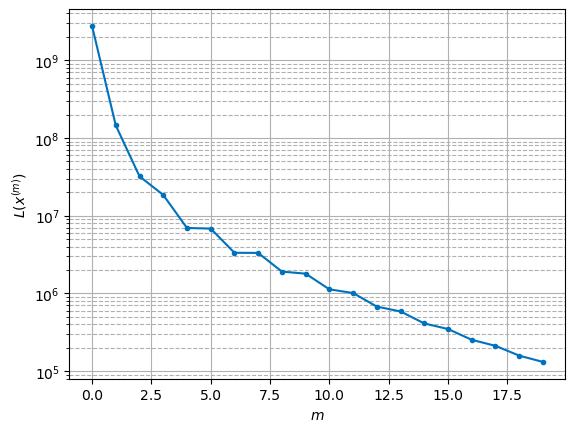

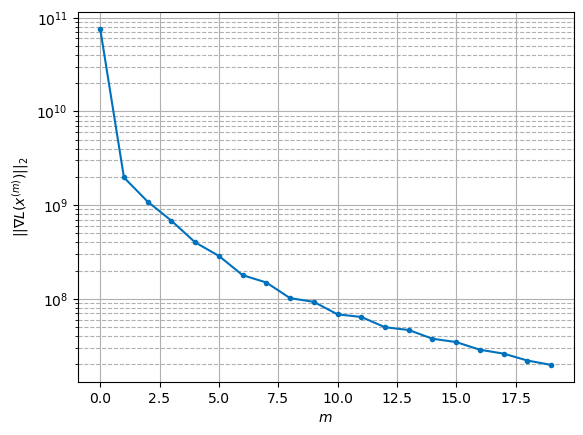

Windows:  10%|█         | 1/10 [00:47<07:07, 47.55s/it]

Before applying the algorithm
Cost function: 129184.20264102991
Gradient norm: 18387794.17889654
Global relative error: 265.242521934516
Position relative errors: 0.08605771796220688 m, 146.73307096771333 m, 174.38131756598673 m, 135.6987041217319 m

Iteration 1
Cost function: 100084.91327223825 (-22.53%)
Gradient norm: 16045522.120127738 (-12.74%)
Global relative error: 249.59789269688466 (-5.90%)
Position relative errors: 0.09271523687275691 m, 133.507658001633 m, 138.75188506989147 m, 158.816573016964 m

Iteration 2
Cost function: 84634.41854069191 (-15.44%)
Gradient norm: 14490405.793293651 (-9.69%)
Global relative error: 235.10779294416608 (-5.81%)
Position relative errors: 0.06340166496048782 m, 128.11913466130062 m, 157.19051553122537 m, 118.96339541375208 m

Iteration 3
Cost function: 66945.968465824 (-20.90%)
Gradient norm: 12722367.947517978 (-12.20%)
Global relative error: 218.6412653910771 (-7.00%)
Position relative errors: 0.07739729052308708 m, 115.74553382714485 m, 122.0

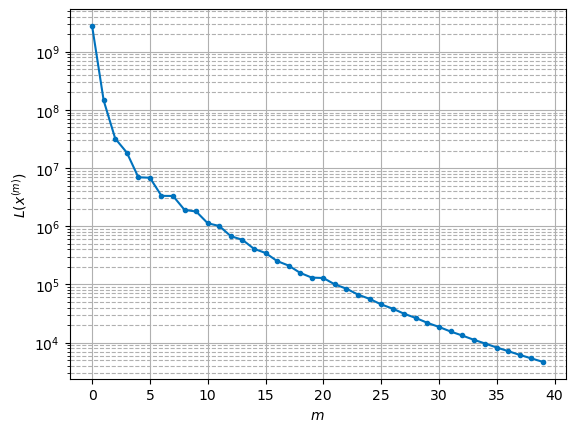

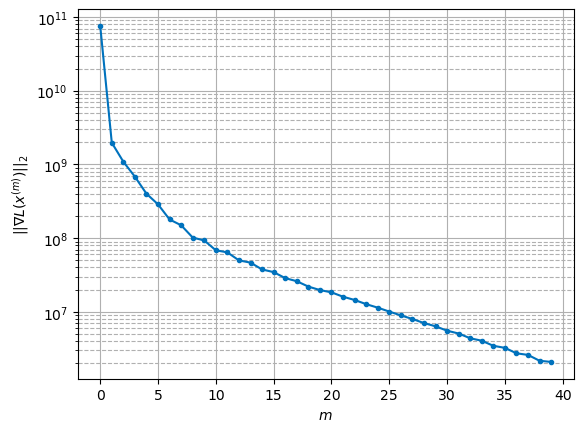

Windows:  20%|██        | 2/10 [01:35<06:20, 47.62s/it]

Before applying the algorithm
Cost function: 4560.522325188161
Gradient norm: 2360819.1829171116
Global relative error: 80.57567233880299
Position relative errors: 0.04559916918971856 m, 41.38460219582093 m, 46.584195436437085 m, 51.08485768091374 m

Iteration 1
Cost function: 3995.310923838286 (-12.39%)
Gradient norm: 1825576.8988116994 (-22.67%)
Global relative error: 76.97640671752161 (-4.47%)
Position relative errors: 0.04329449744893235 m, 39.46715739485823 m, 51.05285213190877 m, 41.968008131342856 m

Iteration 2
Cost function: 3519.1103637742676 (-11.92%)
Gradient norm: 1740575.8152355053 (-4.66%)
Global relative error: 71.59007668702387 (-7.00%)
Position relative errors: 0.046129139159071464 m, 35.454506505249256 m, 42.068400851252505 m, 45.807893077178676 m

Iteration 3
Cost function: 3122.8768514368703 (-11.26%)
Gradient norm: 1393134.177133914 (-19.96%)
Global relative error: 67.76284274293332 (-5.35%)
Position relative errors: 0.04127965002548983 m, 34.31256181825527 m, 44.

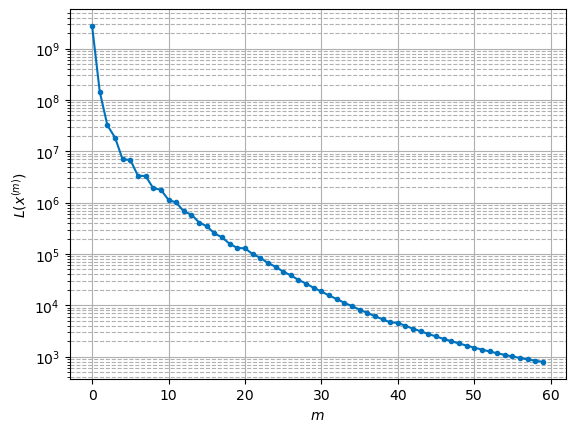

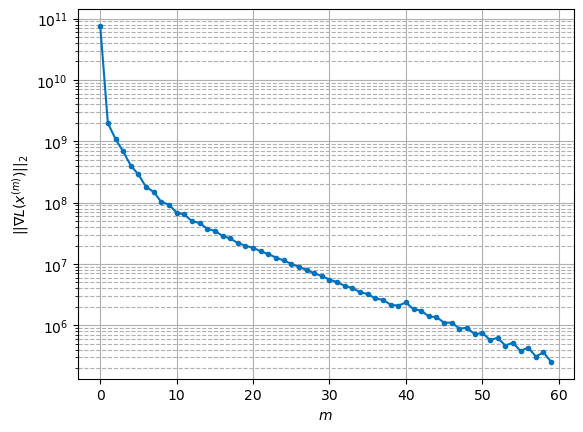

Windows:  30%|███       | 3/10 [02:28<05:51, 50.28s/it]

Before applying the algorithm
Cost function: 791.5797410450629
Gradient norm: 237692.14801512
Global relative error: 25.808300455459364
Position relative errors: 0.037228797835921895 m, 12.263815669519706 m, 16.934254363594892 m, 15.129328898939374 m

Iteration 1
Cost function: 748.4171016604429 (-5.45%)
Gradient norm: 266614.1229990389 (12.17%)
Global relative error: 24.294734391800247 (-5.86%)
Position relative errors: 0.04197361878119625 m, 11.186704455855361 m, 14.96963236783012 m, 15.524169841215912 m

Iteration 2
Cost function: 711.8059938739683 (-4.89%)
Gradient norm: 192296.2746266555 (-27.87%)
Global relative error: 22.74535012812964 (-6.38%)
Position relative errors: 0.04123706720310152 m, 10.495682526855372 m, 14.955104420190045 m, 13.547491762592319 m

Iteration 3
Cost function: 679.7615787210601 (-4.50%)
Gradient norm: 250480.21133308628 (30.26%)
Global relative error: 21.35110733455701 (-6.13%)
Position relative errors: 0.041676466673139845 m, 9.632968714405166 m, 13.1681

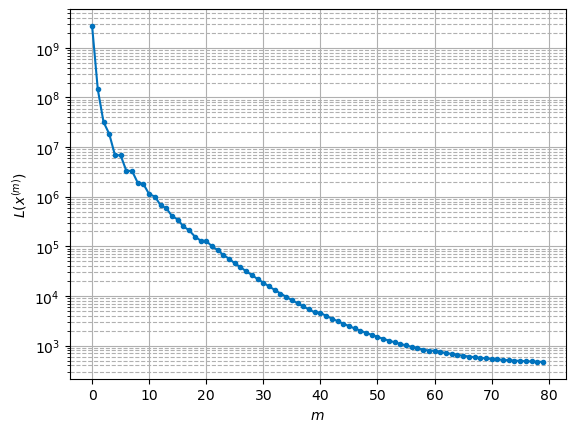

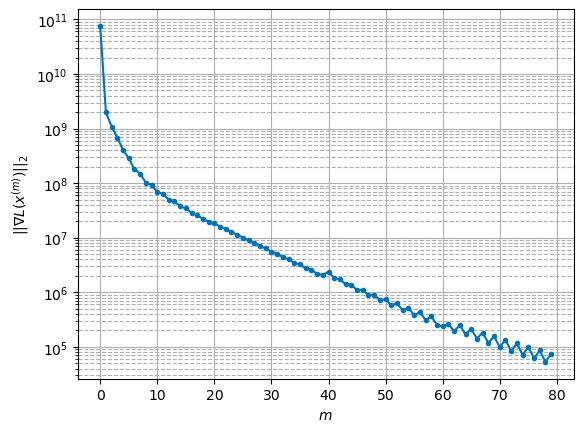

Windows:  40%|████      | 4/10 [03:14<04:51, 48.64s/it]

Before applying the algorithm
Cost function: 475.1833288520711
Gradient norm: 467454.96869185485
Global relative error: 7.98593202792532
Position relative errors: 0.03996256973425894 m, 3.168452617706189 m, 4.892839242024664 m, 5.458433040848649 m

Iteration 1
Cost function: 469.867105859231 (-1.12%)
Gradient norm: 58316.6006240714 (-87.52%)
Global relative error: 7.347190183509189 (-8.00%)
Position relative errors: 0.04340977084957909 m, 3.0175746730335042 m, 4.796402033791025 m, 4.676327984503638 m

Iteration 2
Cost function: 465.7005128194827 (-0.89%)
Gradient norm: 64717.63756445675 (10.98%)
Global relative error: 6.868559333996758 (-6.51%)
Position relative errors: 0.0429696467465807 m, 2.6899222182949996 m, 4.293332480558438 m, 4.637545719681003 m

Iteration 3
Cost function: 462.07307125160213 (-0.78%)
Gradient norm: 40065.82123959271 (-38.09%)
Global relative error: 6.39874611759538 (-6.84%)
Position relative errors: 0.04277717477822532 m, 2.5226643472160757 m, 4.200510730785199

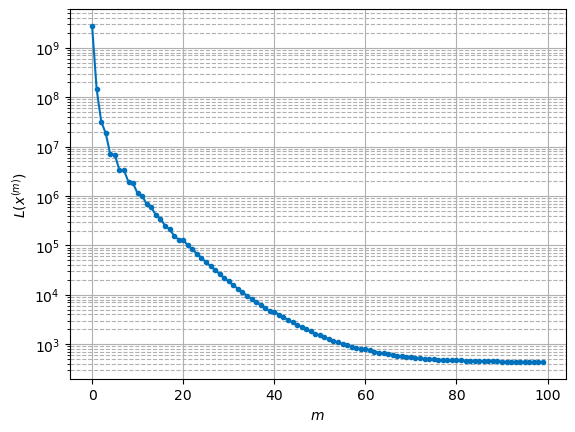

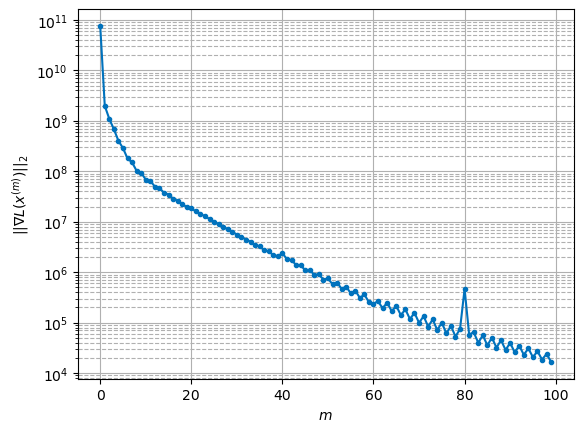

Windows:  50%|█████     | 5/10 [04:00<03:57, 47.55s/it]

Before applying the algorithm
Cost function: 437.6470602107512
Gradient norm: 52298.31047563939
Global relative error: 2.423316152683657
Position relative errors: 0.041582363920770804 m, 0.8541292556540735 m, 1.3295571382100901 m, 1.8366975061016462 m

Iteration 1
Cost function: 436.73110365845594 (-0.21%)
Gradient norm: 34606.38150638288 (-33.83%)
Global relative error: 2.116950488017859 (-12.64%)
Position relative errors: 0.043646399020450026 m, 0.9232509844982763 m, 0.9883278561222795 m, 1.6279974506799875 m

Iteration 2
Cost function: 436.1596614727756 (-0.13%)
Gradient norm: 24378.58342062528 (-29.55%)
Global relative error: 2.0633559084356667 (-2.53%)
Position relative errors: 0.04377138756412605 m, 0.9090485380080556 m, 0.9780424667860644 m, 1.5724412766329072 m

Iteration 3
Cost function: 435.69456656941776 (-0.11%)
Gradient norm: 27338.551881948224 (12.14%)
Global relative error: 1.9361934024042564 (-6.16%)
Position relative errors: 0.04383293174153052 m, 0.9027969248852422 m,

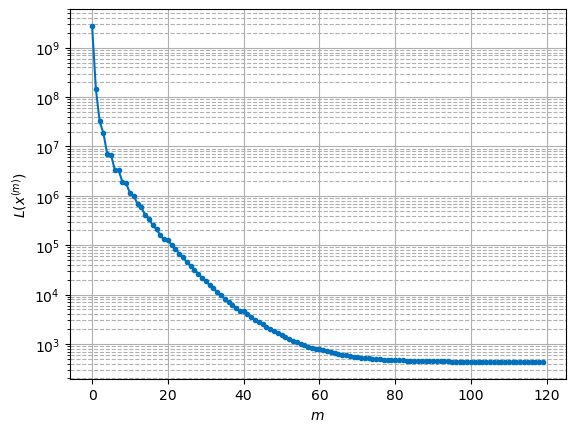

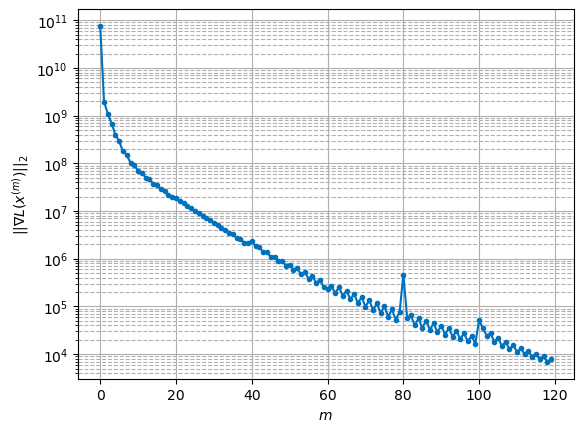

Windows:  60%|██████    | 6/10 [04:48<03:11, 47.81s/it]

Before applying the algorithm
Cost function: 443.7618868880555
Gradient norm: 131699.89685338672
Global relative error: 1.4405485257255766
Position relative errors: 0.04303963081908361 m, 0.8708350539823242 m, 0.238586939721428 m, 1.1216245865429735 m

Iteration 1
Cost function: 442.8551889391198 (-0.20%)
Gradient norm: 35364.031672658646 (-73.15%)
Global relative error: 1.3953310204413234 (-3.14%)
Position relative errors: 0.0550434582685782 m, 0.9743597125006116 m, 0.40297742787789914 m, 0.912218676588215 m

Iteration 2
Cost function: 442.5926525735029 (-0.06%)
Gradient norm: 19502.686821654115 (-44.85%)
Global relative error: 1.4142254779054455 (1.35%)
Position relative errors: 0.054904467699419014 m, 0.9449857189709848 m, 0.398647511940534 m, 0.9721589228867488 m

Iteration 3
Cost function: 442.43185080064956 (-0.04%)
Gradient norm: 15713.160623693804 (-19.43%)
Global relative error: 1.436540229215406 (1.58%)
Position relative errors: 0.054895097595065556 m, 0.966899860105362 m, 0.

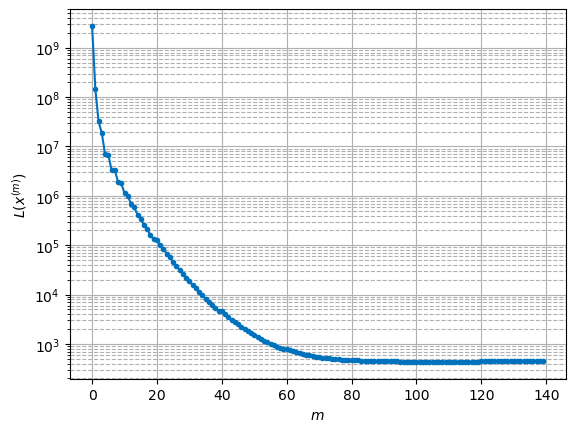

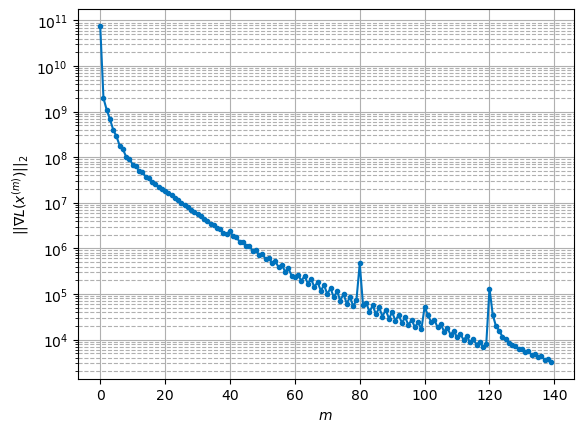

Windows:  70%|███████   | 7/10 [05:37<02:23, 47.98s/it]

Before applying the algorithm
Cost function: 435.68620110260537
Gradient norm: 31368.51731984051
Global relative error: 1.7973906296942368
Position relative errors: 0.053562981745327747 m, 1.0361171357351011 m, 0.8802101310870603 m, 1.1744904154692273 m

Iteration 1
Cost function: 435.20346562744584 (-0.11%)
Gradient norm: 12237.10595271993 (-60.99%)
Global relative error: 1.8073709437556715 (0.56%)
Position relative errors: 0.034912485928089536 m, 0.980973444276902 m, 0.8092764902857169 m, 1.2837935763032262 m

Iteration 2
Cost function: 435.14308661335 (-0.01%)
Gradient norm: 7108.520644465102 (-41.91%)
Global relative error: 1.7888862480523846 (-1.02%)
Position relative errors: 0.03473143621671615 m, 1.0166191862933704 m, 0.8871544727301374 m, 1.174028244930545 m

Iteration 3
Cost function: 435.1126789758925 (-0.01%)
Gradient norm: 6420.561230098966 (-9.68%)
Global relative error: 1.7736462503764618 (-0.85%)
Position relative errors: 0.034712042202564734 m, 0.9735102213965585 m, 0.7

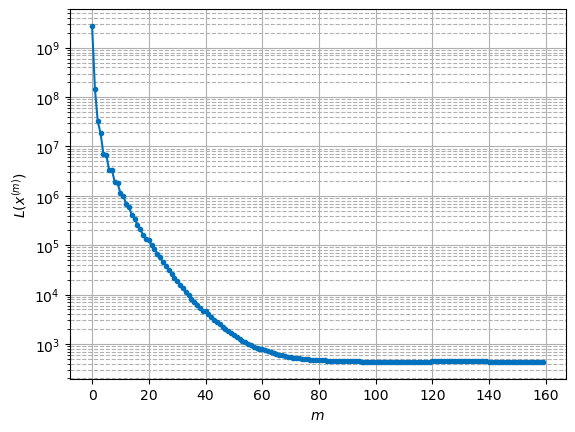

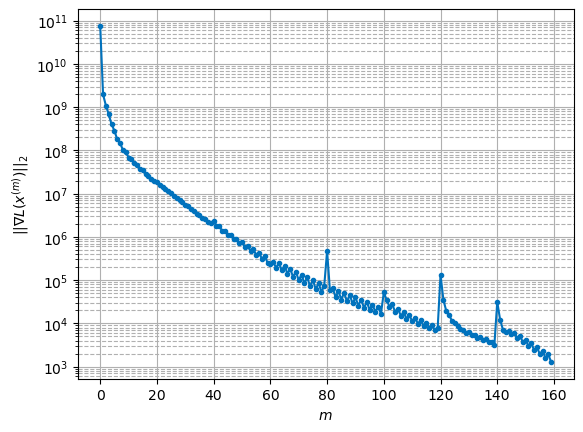

Windows:  80%|████████  | 8/10 [06:22<01:34, 47.30s/it]

Before applying the algorithm
Cost function: 435.35214308816137
Gradient norm: 48193.707924829076
Global relative error: 1.6893402763228442
Position relative errors: 0.03418674497350003 m, 0.8859992275077964 m, 0.8150414881957323 m, 1.1846549385339022 m

Iteration 1
Cost function: 435.0451170282912 (-0.07%)
Gradient norm: 9846.47654809421 (-79.57%)
Global relative error: 1.7679780548074675 (4.65%)
Position relative errors: 0.03716931646558348 m, 0.857439133723659 m, 0.6626357789065666 m, 1.3964489234767017 m

Iteration 2
Cost function: 434.93619914997953 (-0.03%)
Gradient norm: 9603.426579159326 (-2.47%)
Global relative error: 1.8480447678905516 (4.53%)
Position relative errors: 0.037224506705864274 m, 0.9781624139138921 m, 0.8274872482305135 m, 1.3312924014435394 m

Iteration 3
Cost function: 434.87411462228255 (-0.01%)
Gradient norm: 5537.581886769108 (-42.34%)
Global relative error: 1.905298720836871 (3.10%)
Position relative errors: 0.03733340911621763 m, 0.9572216888719587 m, 0.76

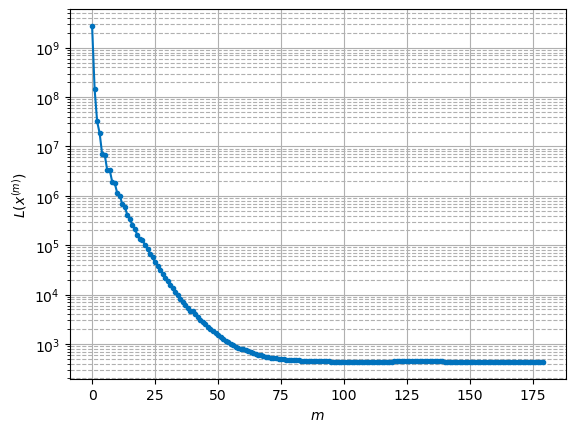

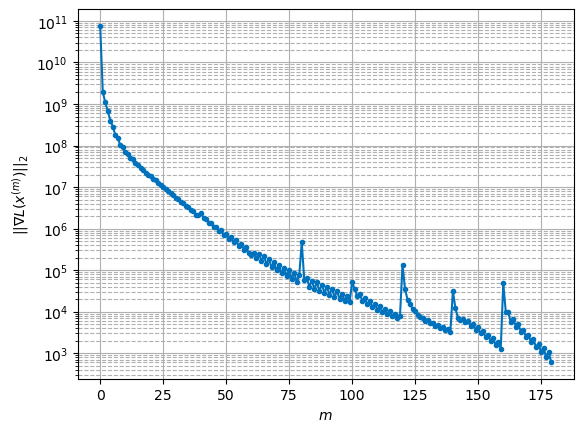

Windows:  90%|█████████ | 9/10 [07:11<00:47, 47.74s/it]

Before applying the algorithm
Cost function: 432.9249586701416
Gradient norm: 91233.72217894788
Global relative error: 2.113722208079751
Position relative errors: 0.03691076984262997 m, 1.0164977567409532 m, 0.9869046073283716 m, 1.5681840570399275 m

Iteration 1
Cost function: 432.7197005621278 (-0.05%)
Gradient norm: 3563.7565152010025 (-96.09%)
Global relative error: 2.1501992035536217 (1.73%)
Position relative errors: 0.041234151699848356 m, 1.0757205079267145 m, 0.8831378350049576 m, 1.6384564397306514 m

Iteration 2
Cost function: 432.6884774836976 (-0.01%)
Gradient norm: 5798.607257004925 (62.71%)
Global relative error: 2.1921782653737796 (1.95%)
Position relative errors: 0.041228500982040006 m, 1.1190288472621712 m, 0.940314907101609 m, 1.6332538512683663 m

Iteration 3
Cost function: 432.6714370163469 (-0.00%)
Gradient norm: 2872.6603021006995 (-50.46%)
Global relative error: 2.218145729615399 (1.18%)
Position relative errors: 0.04119163562775126 m, 1.1238559352066915 m, 0.920

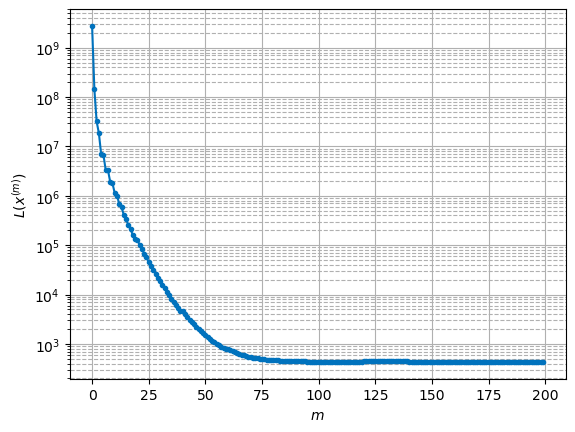

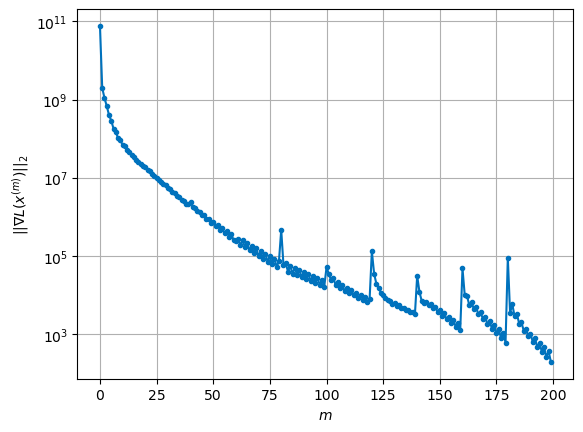

RMSE after convergence:
Chief: 0.05 m
Deputy 1: 48.35 m
Deputy 2: 56.16 m
Deputy 3: 46.27 m


In [151]:
# Main execution loop
def run_estimation():
    
    Y = np.zeros((9, 1, T))
    for t in range(T):
        Y[:, :, t] = h(X_true[:, :, t]) + np.random.normal(0, np.sqrt(np.diag(R)).reshape((9, 1)), size=(9, 1))
        
    # Initialize storage for results
    X_est_mm = np.zeros_like(X_true)
    X_est_mm[:, :, 0] = X_est[:, :, 0]  # Use same initial conditions
    
    # Storage for errors
    errors_chief_mm = []
    errors_deputy1_mm = []
    errors_deputy2_mm = []
    errors_deputy3_mm = []
    
    # Initialize solver
    solver = approxH_Newton()
    
    # Sliding window estimation
    for t in tqdm(range(T - W + 1), desc="Windows", leave=False):
        # Get measurements for current window
        Y_window = Y[:, :, t:t + W]
        
        # Initial guess is the previous estimate propagated forward
        if t == 0:
            x_init = X_est[:, :, t]
        else:
            x_init = X_est_mm[:, :, t]
        
        # Solve the optimization problem
        x_sol = solver.solve(x_init, Y_window, X_true[:, :, t])
        
        # Store the solution
        X_est_mm[:, :, t] = x_sol
        
        # Plot the results
        give_me_the_plots(solver.cost_function_values, solver.grad_norm_values)
        
        # Propagate solution to next timestep if not at the end
        if t < T - W:
            X_est_mm[:, :, t + 1] = SatelliteDynamics().x_new(dt, x_sol)
        
        # Calculate and store errors
        error_chief = np.linalg.norm(X_est_mm[:3, :, t] - X_true[:3, :, t])
        error_deputy1 = np.linalg.norm(X_est_mm[6:9, :, t] - X_true[6:9, :, t])
        error_deputy2 = np.linalg.norm(X_est_mm[12:15, :, t] - X_true[12:15, :, t])
        error_deputy3 = np.linalg.norm(X_est_mm[18:21, :, t] - X_true[18:21, :, t])
        
        errors_chief_mm.append(error_chief)
        errors_deputy1_mm.append(error_deputy1)
        errors_deputy2_mm.append(error_deputy2)
        errors_deputy3_mm.append(error_deputy3)
    
    return X_est_mm, errors_chief_mm, errors_deputy1_mm, errors_deputy2_mm, errors_deputy3_mm

# Run the estimation
X_est_mm, errors_chief_mm, errors_deputy1_mm, errors_deputy2_mm, errors_deputy3_mm = run_estimation()

# Print RMSE for each satellite
print("RMSE after convergence:")
print(f"Chief: {np.sqrt(np.mean(np.array(errors_chief_mm[T_RMSE:])**2)):.2f} m")
print(f"Deputy 1: {np.sqrt(np.mean(np.array(errors_deputy1_mm[T_RMSE:])**2)):.2f} m")
print(f"Deputy 2: {np.sqrt(np.mean(np.array(errors_deputy2_mm[T_RMSE:])**2)):.2f} m")
print(f"Deputy 3: {np.sqrt(np.mean(np.array(errors_deputy3_mm[T_RMSE:])**2)):.2f} m")

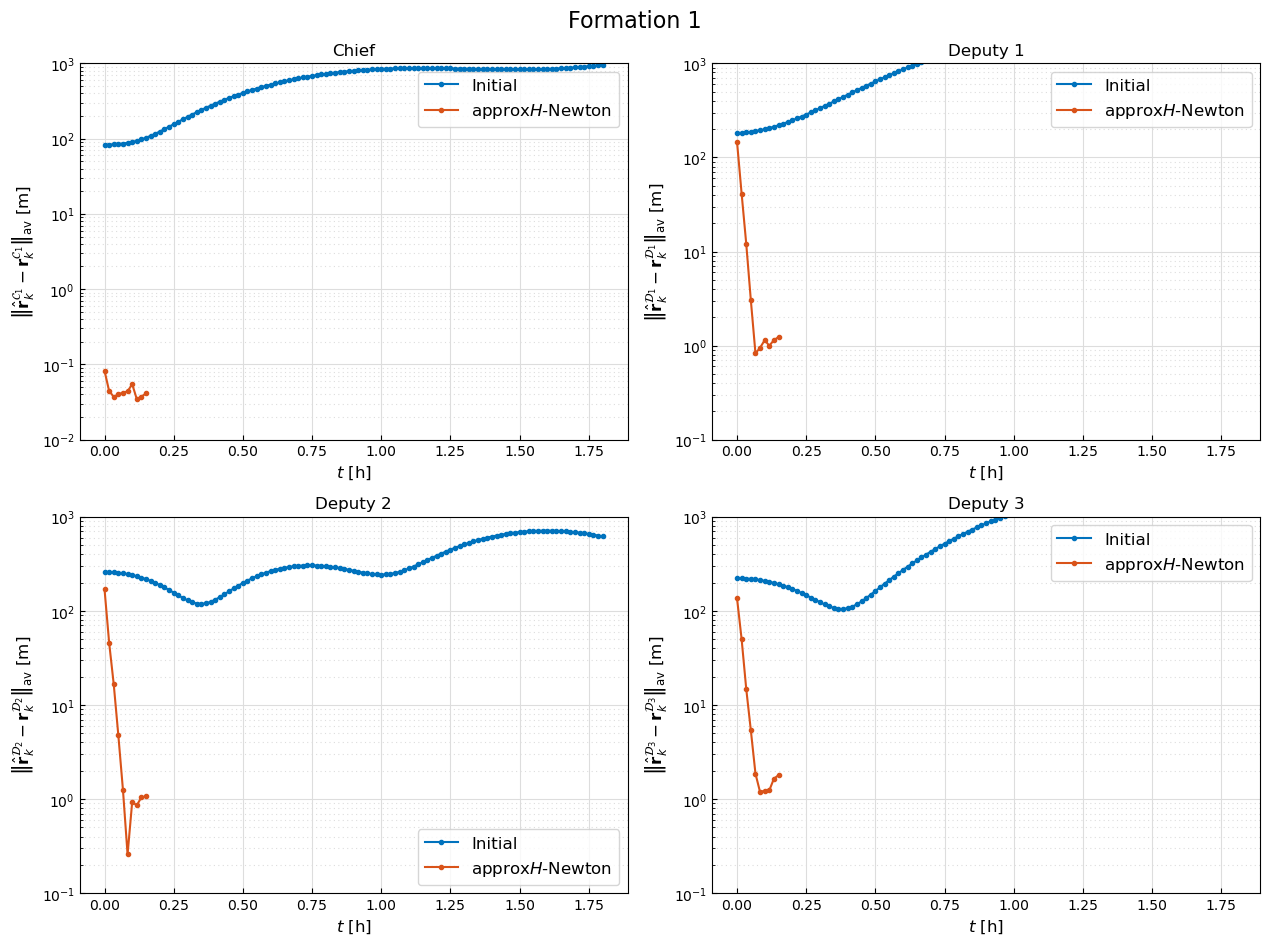

In [153]:
dev_chief = errors_chief_mm
dev_deputy1 = errors_deputy1_mm
dev_deputy2 = errors_deputy2_mm
dev_deputy3 = errors_deputy3_mm

# MATLAB default color cycle
matlab_default_colors = [
    [0, 0.4470, 0.7410],  # blue
    [0.8500, 0.3250, 0.0980],  # orange
    [0.9290, 0.6940, 0.1250],  # yellow
    [0.4940, 0.1840, 0.5560],  # purple
    [0.4660, 0.6740, 0.1880],  # green
    [0.3010, 0.7450, 0.9330],  # light blue
    [0.6350, 0.0780, 0.1840],  # red
]
# Set the color cycle in Matplotlib to match MATLAB's default
plt.rcParams["axes.prop_cycle"] = plt.cycler(color=matlab_default_colors)

time = np.arange(0, T) / dt
algorithm = "approx$H$-Newton"

# Plot positions based on screen size
fig_width = 2 * 6.4  # in inchesa
fig_height = 2 * 4.8  # in inches

# Create a 2 by 2 figure
fig, axs = plt.subplots(2, 2, figsize=(fig_width, fig_height))

# Plot 1: Chief
axs[0, 0].plot(time, dev_chief_initial, ".-", label="Initial")
axs[0, 0].plot(time[:K - W + 1], dev_chief, ".-", label=algorithm)
axs[0, 0].grid(which="major", color="#DDDDDD", zorder=1)
axs[0, 0].grid(which="minor", color="#DDDDDD", linestyle=(0, (1, 3)), zorder=2)
axs[0, 0].grid(True, which="both")
axs[0, 0].set_yscale("log")
axs[0, 0].set_xlabel("$t$ [h]", fontsize=12)
axs[0, 0].set_ylabel(
    "$\\left\\|\\hat{\\mathbf{r}}_k^{\\mathcal{C}_1} - \\mathbf{r}_k^{\\mathcal{C}_1}\\right\\|_\\mathrm{av}$ [m]",
    fontsize=12,
)
axs[0, 0].set_ylim([1e-2, 1e3])
axs[0, 0].tick_params(axis="both", which="both", direction="in")
axs[0, 0].legend(fontsize=12)
axs[0, 0].set_title("Chief")

# Plot 2: Deputy 1
axs[0, 1].plot(time, dev_deputy1_initial, ".-", label="Initial")
axs[0, 1].plot(time[:K - W + 1], dev_deputy1, ".-", label=algorithm)
axs[0, 1].grid(which="major", color="#DDDDDD", zorder=1)
axs[0, 1].grid(which="minor", color="#DDDDDD", linestyle=(0, (1, 3)), zorder=2)
axs[0, 1].grid(True, which="both")
axs[0, 1].set_yscale("log")
axs[0, 1].set_xlabel("$t$ [h]", fontsize=12)
axs[0, 1].set_ylabel(
    "$\\left\\|\\hat{\\mathbf{r}}_k^{\\mathcal{D}_1} - \\mathbf{r}_k^{\\mathcal{D}_1}\\right\\|_\\mathrm{av}$ [m]",
    fontsize=12,
)
axs[0, 1].set_ylim([1e-1, 1e3])
axs[0, 1].tick_params(axis="both", which="both", direction="in")
axs[0, 1].legend(fontsize=12)
axs[0, 1].set_title("Deputy 1")

# Plot 3: Deputy 2
axs[1, 0].plot(time, dev_deputy2_initial, ".-", label="Initial")
axs[1, 0].plot(time[:K - W + 1], dev_deputy2, ".-", label=algorithm)
axs[1, 0].grid(which="major", color="#DDDDDD", zorder=1)
axs[1, 0].grid(which="minor", color="#DDDDDD", linestyle=(0, (1, 3)), zorder=2)
axs[1, 0].grid(True, which="both")
axs[1, 0].set_yscale("log")
axs[1, 0].set_xlabel("$t$ [h]", fontsize=12)
axs[1, 0].set_ylabel(
    "$\\left\\|\\hat{\\mathbf{r}}_k^{\\mathcal{D}_2} - \\mathbf{r}_k^{\\mathcal{D}_2}\\right\\|_\\mathrm{av}$ [m]",
    fontsize=12,
)
axs[1, 0].set_ylim([1e-1, 1e3])
axs[1, 0].tick_params(axis="both", which="both", direction="in")
axs[1, 0].legend(fontsize=12)
axs[1, 0].set_title("Deputy 2")

# Plot 4: Deputy 3
axs[1, 1].plot(time, dev_deputy3_initial, ".-", label="Initial")
axs[1, 1].plot(time[:K - W + 1], dev_deputy3, ".-", label=algorithm)
axs[1, 1].grid(which="major", color="#DDDDDD", zorder=1)
axs[1, 1].grid(which="minor", color="#DDDDDD", linestyle=(0, (1, 3)), zorder=2)
axs[1, 1].grid(True, which="both")
axs[1, 1].set_yscale("log")
axs[1, 1].set_xlabel("$t$ [h]", fontsize=12)
axs[1, 1].set_ylabel(
    "$\\left\\|\\hat{\\mathbf{r}}_k^{\\mathcal{D}_3} - \\mathbf{r}_k^{\\mathcal{D}_3}\\right\\|_\\mathrm{av}$ [m]",
    fontsize=12,
)
axs[1, 1].set_ylim([1e-1, 1e3])
axs[1, 1].tick_params(axis="both", which="both", direction="in")
axs[1, 1].legend(fontsize=12)
axs[1, 1].set_title("Deputy 3")

fig.suptitle(f"Formation {formation}", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()